<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025/blob/main/DL_day15/15_2_denoising_diffusion_probabilistic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Model

Reference: https://github.com/Jackson-Kang/Pytorch-Diffusion-Model-Tutorial

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 20

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y

In [6]:
class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)


    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)

        y = self.out_project(y)

        return y

model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps).to(DEVICE)

### Define Gaussian Diffusion

In [7]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon


    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon


    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### Visualizing forward process

In [9]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [10]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

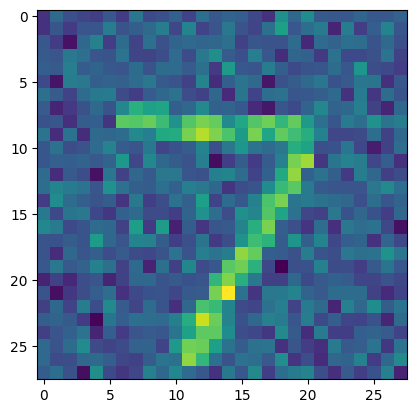

In [11]:
show_image(perturbed_images, idx=0)

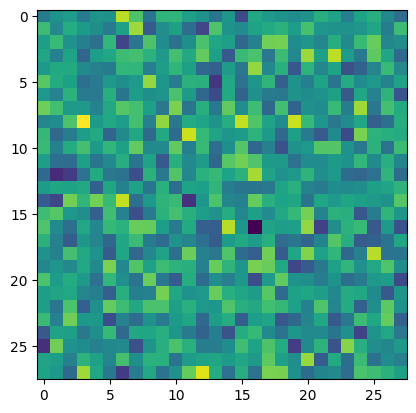

In [12]:
show_image(perturbed_images, idx=1)

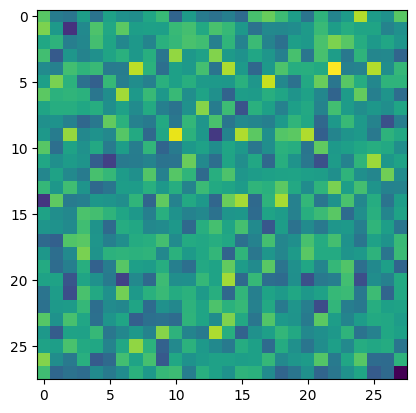

In [13]:
show_image(perturbed_images, idx=2)

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

In [14]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)

        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

print("Finish!!")

Start training DDPMs...


100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 1 complete! 	Denoising Loss:  0.0910968461042095



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 2 complete! 	Denoising Loss:  0.03919612469836178



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 3 complete! 	Denoising Loss:  0.03505607129623874



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 4 complete! 	Denoising Loss:  0.033041791126736976



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 5 complete! 	Denoising Loss:  0.03155819753694356



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 6 complete! 	Denoising Loss:  0.03052201749693252



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 7 complete! 	Denoising Loss:  0.029725062728533123



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 8 complete! 	Denoising Loss:  0.029020581856115252



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 9 complete! 	Denoising Loss:  0.028725996641362578



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 10 complete! 	Denoising Loss:  0.028214115510161362



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 11 complete! 	Denoising Loss:  0.027788312994262092



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 12 complete! 	Denoising Loss:  0.027278703585680988



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 13 complete! 	Denoising Loss:  0.02710014869037092



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 14 complete! 	Denoising Loss:  0.026857265836407997



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 15 complete! 	Denoising Loss:  0.026807131337272562



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 16 complete! 	Denoising Loss:  0.02666895769727536



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 17 complete! 	Denoising Loss:  0.02623993479527342



100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 18 complete! 	Denoising Loss:  0.02616158751054452



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 19 complete! 	Denoising Loss:  0.02615457570626058



100%|██████████| 469/469 [05:22<00:00,  1.46it/s]

	Epoch 20 complete! 	Denoising Loss:  0.02567238440243607
Finish!!


## Step 4. Sample images from noise.

In [15]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

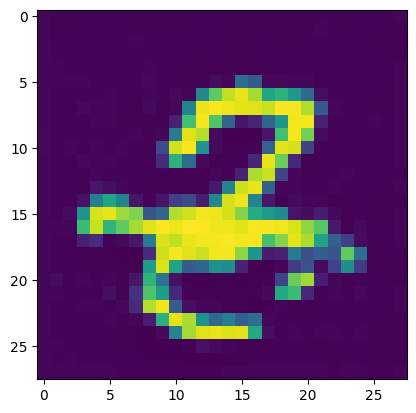

In [16]:
show_image(generated_images, idx=0)

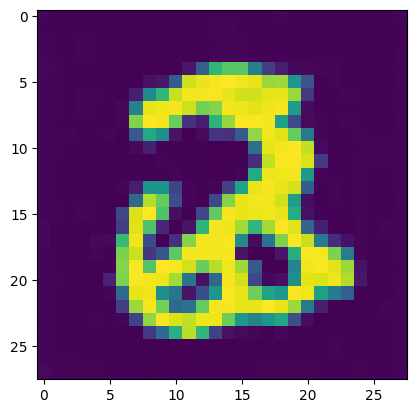

In [17]:
show_image(generated_images, idx=1)

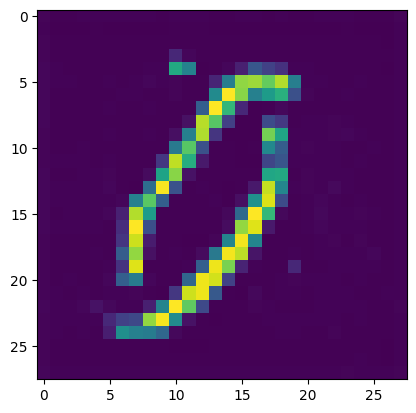

In [18]:
show_image(generated_images, idx=2)

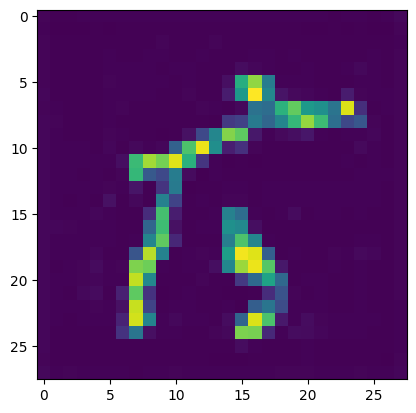

In [19]:
show_image(generated_images, idx=3)

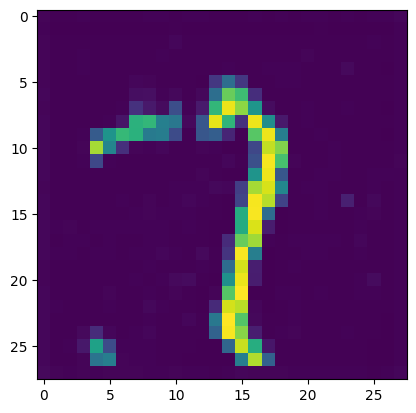

In [20]:
show_image(generated_images, idx=4)

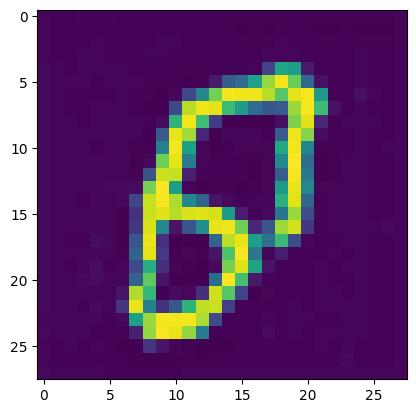

In [21]:
show_image(generated_images, idx=5)

### Comparison with ground-truth samples

In [22]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

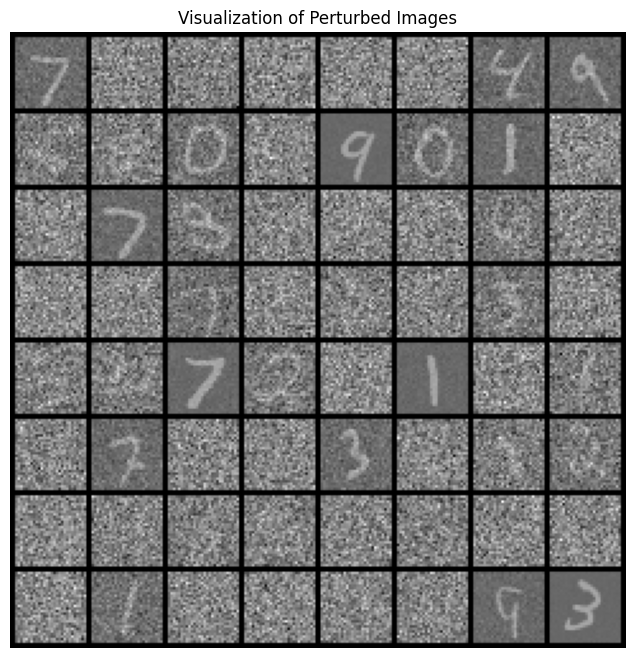

In [23]:
draw_sample_image(perturbed_images, "Perturbed Images")

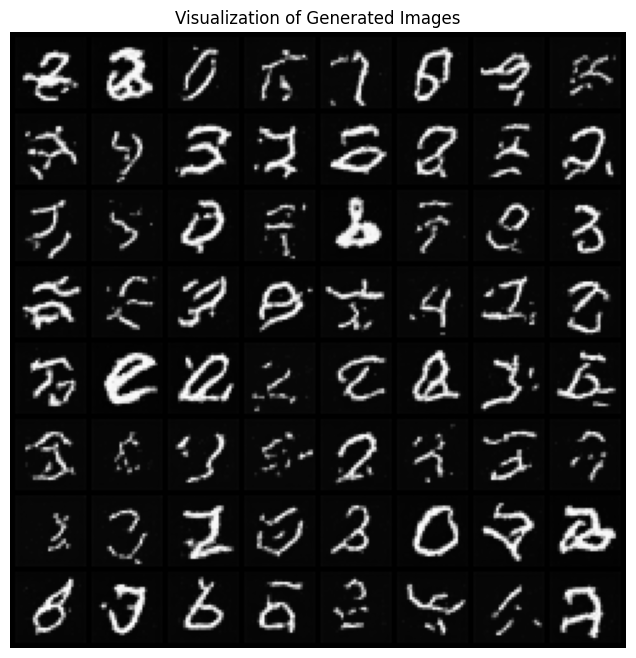

In [24]:
draw_sample_image(generated_images, "Generated Images")

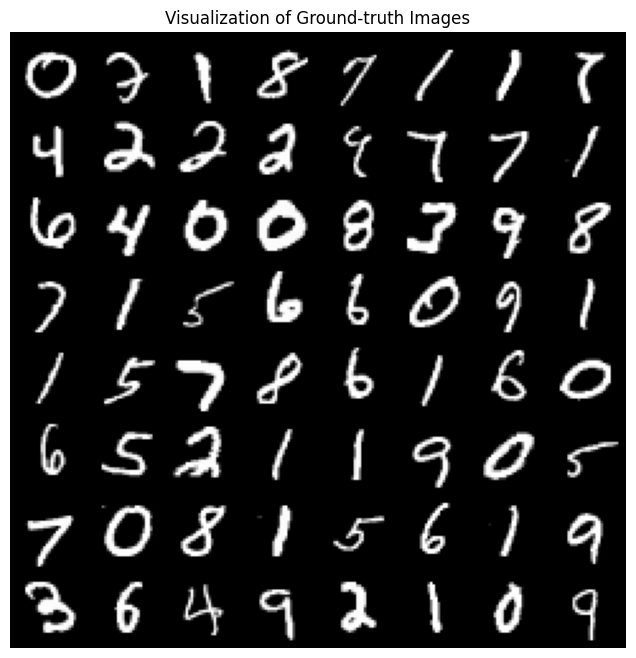

In [25]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")

If you raise the epoch to 200, generated images will look much better!